# Electricity Prediction

In [2]:

import warnings
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import time

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_absolute_error
from statsmodels.tsa.arima.model import ARIMA

warnings.filterwarnings("ignore")

In [3]:
def wrangle(file_path, resample='1H'):
    # read CSV file
    df_first = pd.read_csv(file_path)

    # extract required columns
    df = df_first[['Date', 'Time', 'Global_active_power']].copy()
    df.rename(columns={'Global_active_power': 'Energy'}, inplace=True)

    # convert column to date time column
    df['Timestamp'] = pd.to_datetime(df['Date'] + " " + df['Time'])

    # set timestamp as index
    df = df.set_index('Timestamp')

    # convert 'Energy' column to float
    df["Energy"] = pd.to_numeric(df["Energy"], errors="coerce")

     # drop columns
    df.drop(columns=['Date', 'Time'], inplace=True)

    # foward fill NA values
    y = df['Energy'].resample(resample).mean().fillna(method='ffill')

    return y

In [41]:
y = wrangle('./household_power_consumption.csv')
y.head()

Timestamp
2007-01-01 00:00:00    2.550633
2007-01-01 01:00:00    2.523400
2007-01-01 02:00:00    2.582333
2007-01-01 03:00:00    2.541667
2007-01-01 04:00:00    2.475733
Freq: h, Name: Energy, dtype: float64

# Model 1 (Jan-Mar)

In [48]:
y_1 = y.loc['2007-01-01':'2007-04-30']

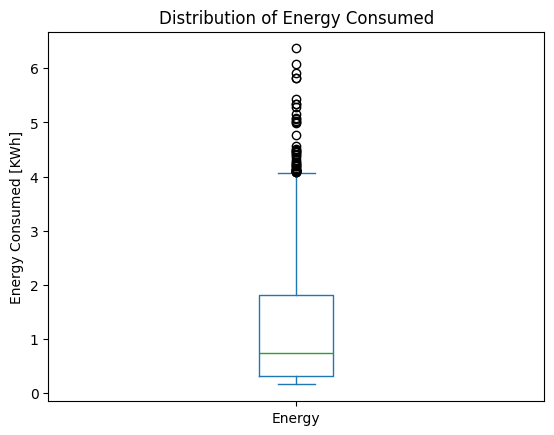

In [50]:
y_1.plot(kind='box')
plt.ylabel('Energy Consumed [KWh]')
plt.title('Distribution of Energy Consumed');

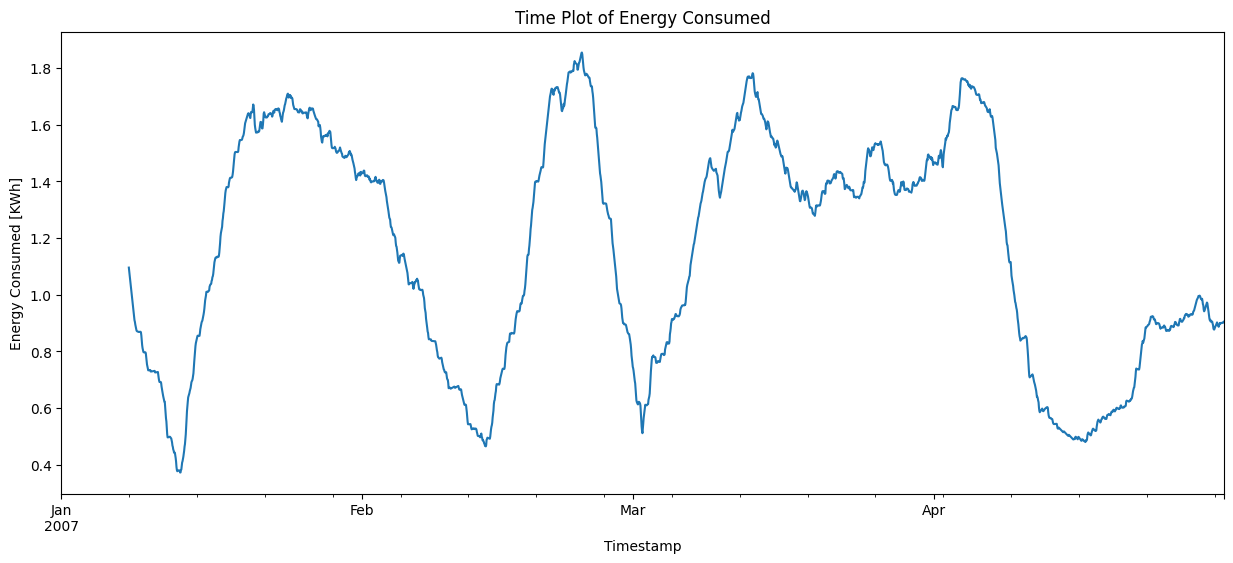

In [ ]:
fig, ax = plt.subplots(figsize=(15, 6))
y_1.rolling(168).mean().plot()
plt.ylabel('Energy Consumed [KWh]')
plt.title('Time Plot of Energy Consumed');

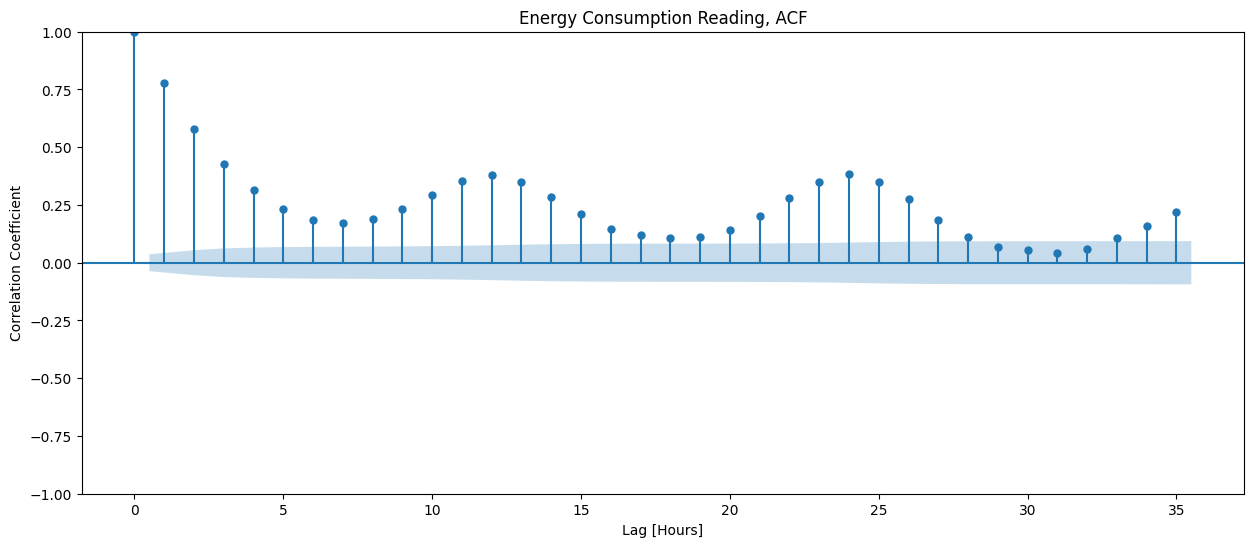

In [ ]:
fig, ax = plt.subplots(figsize=(15, 6))
plot_acf(y_1, ax=ax)
plt.xlabel('Lag [Hours]')
plt.ylabel('Correlation Coefficient')
plt.title('Energy Consumption Reading, ACF');

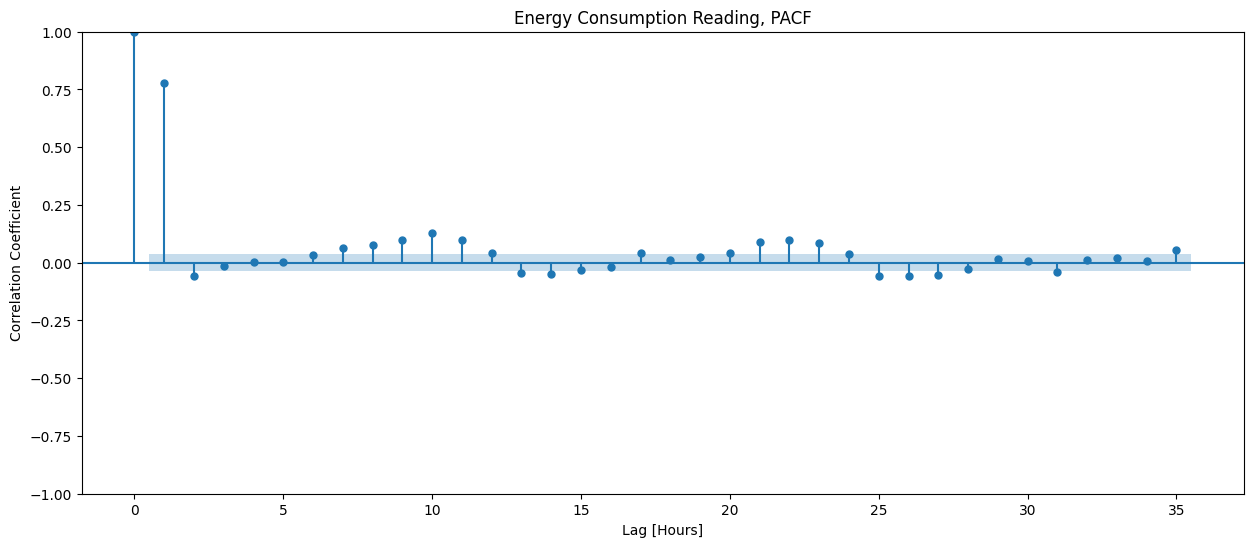

In [ ]:
fig, ax = plt.subplots(figsize=(15, 6))
plot_pacf(y_1, ax=ax)
plt.xlabel('Lag [Hours]')
plt.ylabel('Correlation Coefficient')
plt.title('Energy Consumption Reading, PACF');

## Split Data

In [ ]:
y_train = y_1.loc['2007-01-01': '2007-03-31']
y_test = y_1.loc['2007-04-01':'2007-04-30']

## Build Baseline

In [ ]:
y_pred_base = [y_train.mean()] * len(y_train)
y_pred_mae = mean_absolute_error(y_pred_base, y_train)
print(f'The mean is {round(y_train.mean(), 2)} and mean absolute error is {round(y_pred_mae, 2)}')

The mean is 1.25 and mean absolute error is 0.87


## Build Model

In [75]:
p_params = range(0, 6)
q_params = range(0, 3)

In [ ]:
mae_grid = dict()

for p in p_params:
    mae_grid[p] = list()

    for q in q_params:

        order = (p, 0, q)

        start_time = time.time()
        model = ARIMA(y_train, order=order).fit()

        aic = model.aic
        bic = model.bic

        elapsed_time = round(time.time() - start_time, 2)

        print(f'Trained ARIMA {order} in {elapsed_time}s with AIC of {round(aic, 2)} and BIC of {round(bic, 2)}.')

        y_pred = model.predict()

        pred_mae = mean_absolute_error(y_pred, y_train)

        mae_grid[p].append(pred_mae)

print()
mae_grid

In [ ]:
mae_df = pd.DataFrame(mae_grid)
mae_df

,0,1,2,3,4,5
0,0.866958,0.449791,0.450433,0.451220,0.451180,0.451237
1,0.615477,0.450210,0.451159,0.450898,0.451069,0.451199
2,0.530669,0.451042,0.451250,0.451121,0.451125,0.451557


In [ ]:
y_pred_wfv = pd.Series()
history = y_train.copy()

for i in range(len(y_test)):
    model = ARIMA(history,
                  order=(2, 0, 0)).fit()
    next_pred = model.forecast()
    
    # collect forecast
    y_pred_wfv = pd.concat([y_pred_wfv, next_pred])
    
    # add the actual observation from test set
    history = pd.concat([history, y_test.iloc[[i]]])


In [ ]:
test_mae = mean_absolute_error(y_test, y_pred_wfv)
print(f'Test MAE (walk forward validation): {round(test_mae, 2)}')

Test MAE (walk forward validation): 0.36


In [ ]:
df_predictions = pd.DataFrame({
    'pred_wfv': y_pred_wfv,
    'y_test': y_test
})

In [ ]:
fig = px.line(df_predictions, labels={'value': 'Energy'})
fig.show()

# Model 2 (Apr-Jun)

In [44]:
y_2 = y.loc['2007-04-01': '2007-07-31']

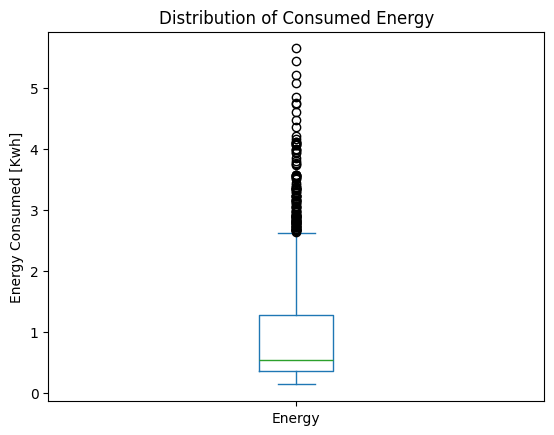

In [53]:
y_2.plot(kind='box')
plt.ylabel('Energy Consumed [Kwh]')
plt.title('Distribution of Consumed Energy');

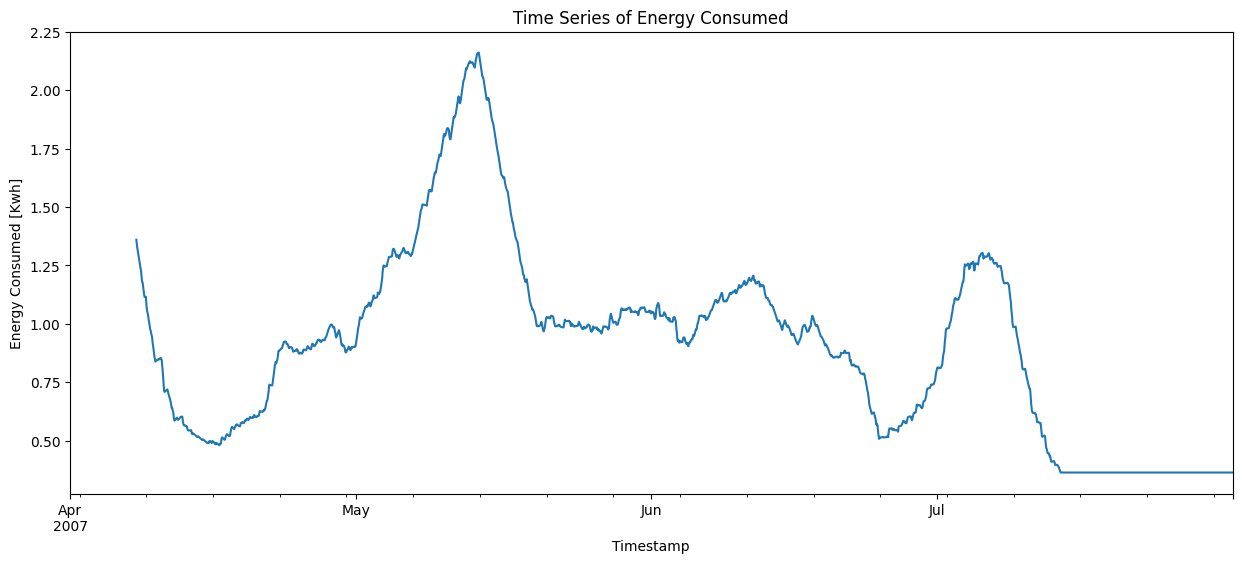

In [56]:
fig, ax = plt.subplots(figsize=(15, 6))
y_2.rolling(168).mean().plot()
plt.ylabel('Energy Consumed [Kwh]')
plt.title('Time Series of Energy Consumed');

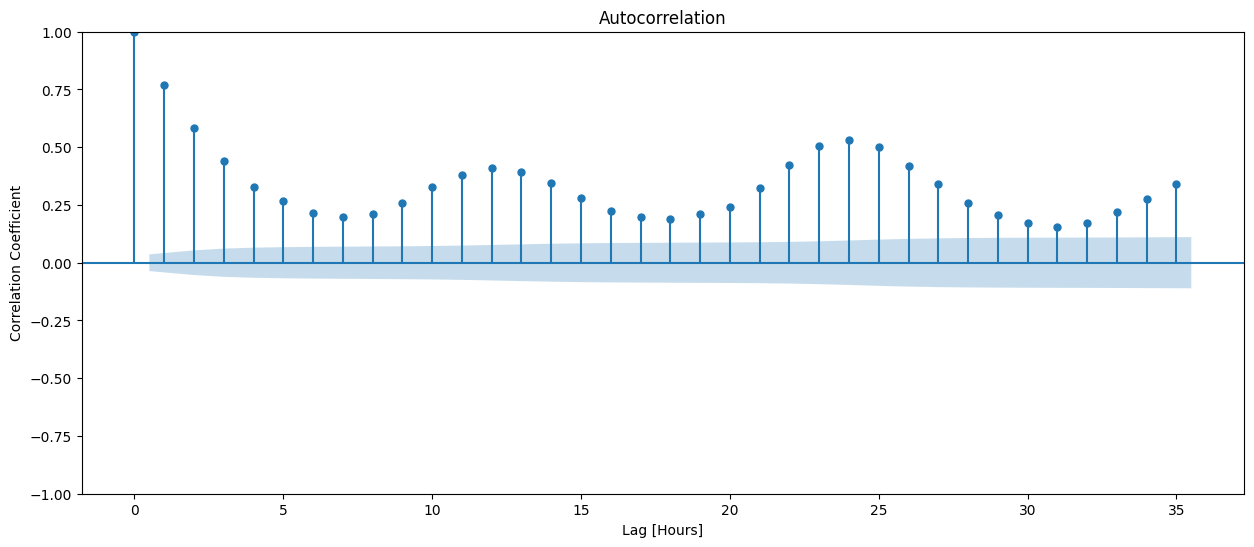

In [60]:
fig, ax = plt.subplots(figsize=(15,6))
plot_acf(y_2, ax=ax)
plt.ylabel('Correlation Coefficient')
plt.xlabel('Lag [Hours]');

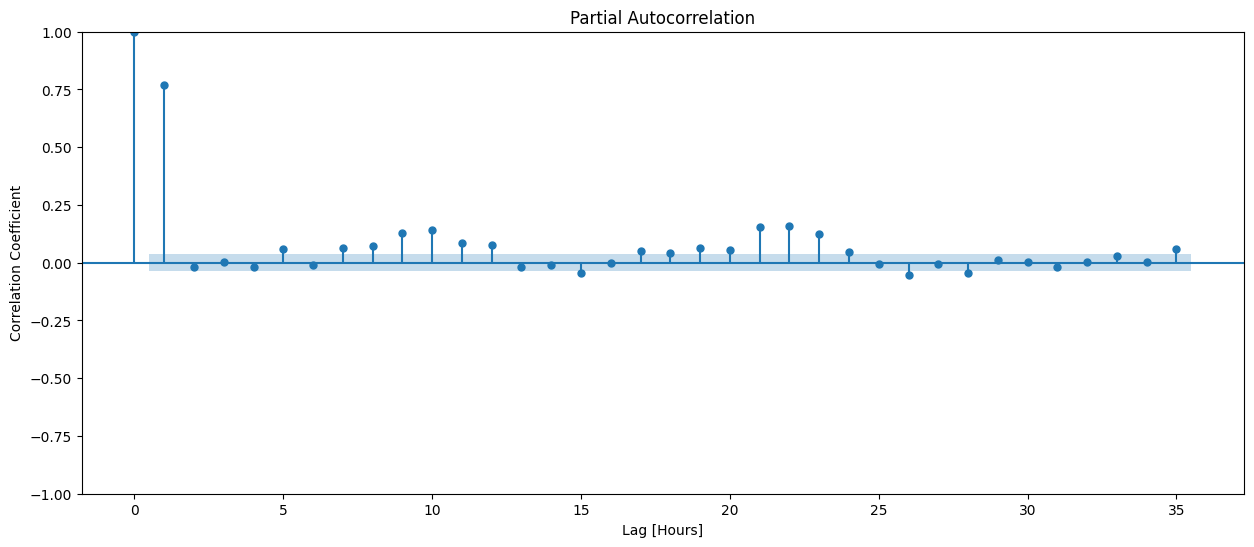

In [62]:
fig, ax = plt.subplots(figsize=(15,6))
plot_pacf(y_2, ax=ax)
plt.ylabel('Correlation Coefficient')
plt.xlabel('Lag [Hours]');

## Split Data

In [70]:
y_train = y_2.loc[:'2007-06-30']
y_test = y_2.loc['2007-07-01':]

## Build Baseline

In [73]:
y_pred_base = [y_train.mean()] * len(y_train)
base_mae = mean_absolute_error(y_train, y_pred_base)
print(f'The mean energy consumed: {round(y_train.mean(), 2)}')
print(f'The Baseline MAE: {round(base_mae, 2)}')


The mean energy consumed: 1.04
The Baseline MAE: 0.68


## Build Model

In [80]:
mae_grid = dict()

for p in p_params:
    mae_grid[p] = list()

    for q in q_params:
        order = (p,0,q)

        start_time = time.time()

        model = ARIMA(y_train, order=order).fit()

        aic = round(model.aic, 2)
        bic = round(model.bic, 2)

        elapsed_time = round(time.time() - start_time, 2)

        print(f'Trained ARMA model {order} in {elapsed_time}s')
        print(f'AIC: {aic}, BIC: {bic}')

        y_pred = model.predict()

        train_mae = mean_absolute_error(y_train, y_pred)

        mae_grid[p].append(train_mae)

print()


Trained ARMA model (0, 0, 0) in 0.47s
AIC: 5496.59, BIC: 5507.96
Trained ARMA model (0, 0, 1) in 0.58s
AIC: 4341.49, BIC: 4358.55
Trained ARMA model (0, 0, 2) in 1.58s
AIC: 4001.25, BIC: 4024.01
Trained ARMA model (1, 0, 0) in 0.36s
AIC: 3741.96, BIC: 3759.02
Trained ARMA model (1, 0, 1) in 0.46s
AIC: 3742.12, BIC: 3764.88
Trained ARMA model (1, 0, 2) in 1.64s
AIC: 3743.57, BIC: 3772.02
Trained ARMA model (2, 0, 0) in 0.68s
AIC: 3742.05, BIC: 3764.8
Trained ARMA model (2, 0, 1) in 2.23s
AIC: 3743.52, BIC: 3771.96
Trained ARMA model (2, 0, 2) in 5.67s
AIC: 3729.66, BIC: 3763.8
Trained ARMA model (3, 0, 0) in 0.97s
AIC: 3743.48, BIC: 3771.93
Trained ARMA model (3, 0, 1) in 7.3s
AIC: 3729.62, BIC: 3763.75
Trained ARMA model (3, 0, 2) in 8.38s
AIC: 3682.53, BIC: 3722.36
Trained ARMA model (4, 0, 0) in 0.92s
AIC: 3744.47, BIC: 3778.6
Trained ARMA model (4, 0, 1) in 2.66s
AIC: 3742.36, BIC: 3782.19
Trained ARMA model (4, 0, 2) in 7.51s
AIC: 3738.86, BIC: 3784.37
Trained ARMA model (5, 0, 0) 

In [81]:
mae_df = pd.DataFrame(mae_grid)
mae_df.head()

,0,1,2,3,4,5
0,0.680422,0.381869,0.382278,0.382508,0.382621,0.382636
1,0.495136,0.382241,0.382473,0.380791,0.382539,0.382535
2,0.440751,0.382465,0.380760,0.368645,0.382371,0.361626


You picked (2,0,0)